### cw_separation

- This notebook takes a look at making some plots having associated galaxies with certain cw morphological features.

In [9]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kin_morph_funcs as knf
from astropy.cosmology import Planck15
from scipy import interpolategi
import scipy.stats as stats
import scipy
import spin_bias_funcs as sbf
import seaborn as sns
import imp
imp.reload(sbf)
from matplotlib import rcParams
sbf.plot_default(rcParams)

In [74]:
# loading in cosmic web catalogues and matching manga ids to get info for all MaNGA targets.
inpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/catalogues/'
outpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/plots/cosmo_web_split/'

mid = pd.read_csv(inpath+'MaNGA_IDs')
cw = pd.read_csv(inpath+'CW_mpl6_yang_s5.csv')#'CW_SDSS_GC1_S3/DR10_MaNGA_matched_S3.csv')

# merging catalogues and finding manga targets only.
cw_manga_targets = mid.merge(cw, left_on='ID', right_on='ID')

# match to morphology information.
gz = pd.read_csv(inpath+'MaNGA_gz-v1_0_1.csv')
cw_manga_targets_gz = cw_manga_targets.merge(gz, on='MANGAID')

# matching this to my own catalogue because pipe3d don't know what a mangaid is.
mpl8 = pd.read_csv(inpath+'mpl8_main_TNG_ref.csv')
cw_gz_mpl8 = mpl8.merge(cw_manga_targets_gz, left_on='mangaid', right_on='MANGAID')

# matching to angular momentum info.
pipe3d = pd.read_csv(inpath+'manga.Pipe3D_v2_5_3.csv')
cw_gz_pipe3d_mpl8 = cw_gz_mpl8.merge(pipe3d, left_on='plateifu', right_on='plateifu')

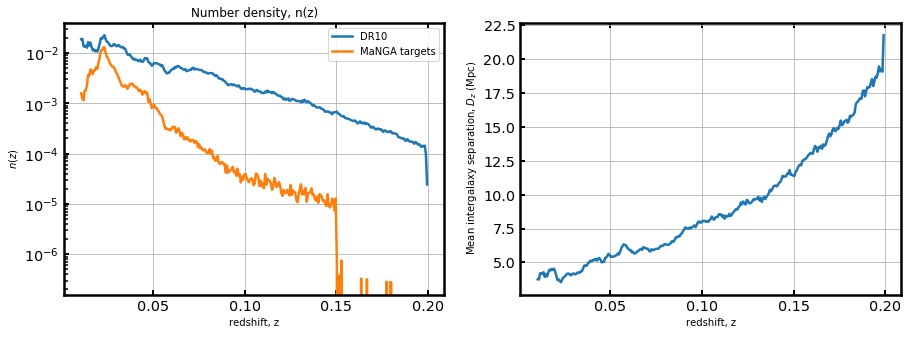

In [75]:
# SDSS DR10 (7966 sq deg) with the redshift limit of z=0.2.
DR10 = fits.open(inpath+'CW_mpl6_yang_s5')[1].data
z_dr10 = DR10['zobs'][(DR10['zobs'] <= 0.2) & (DR10['zobs'] >= 0)]

# Finding redshift range of MaNGA targets only! 
mngtarg_min = min(DR10['zobs'][DR10['ID'] != - 9999])
mngtarg_max = max(DR10['zobs'][DR10['ID'] != - 9999])
# Number of galaxies per redshift bin.
fig,ax = plt.subplots(1,2,figsize=(15,5))
plt.sca(ax[0])
N_z = np.histogram(z_dr10,bins=np.linspace(mngtarg_min,0.2,301))
N_z_manga = np.histogram(DR10['zobs'][DR10['ID'] != - 9999],bins=N_z[1])

#ax[1].plot([np.mean(D_z[:-1]).value,np.mean(D_z[:-1]).value],[0,3500],'k-.')

# Finding the fraction of the sky covered by DR10.
whole_sky_area = 4*np.pi*(180/np.pi)**2 # steradians converted to sq degs.
frac = 7966 / whole_sky_area
# So e.g. volume up to redshift of 0.1
total_vols = frac*Planck15.comoving_volume(N_z[1])
slice_vols = total_vols[1:] - total_vols[:-1]

# So for each redshift slice n = N/V:
number_density = N_z[0] / slice_vols
number_density_manga = N_z_manga[0] / slice_vols

# Now finding the euclidean inter galaxy separation as a function of redshift.
D_z = number_density**(-1/3)

# Finding bin centres
bin_cen = (N_z[1][:-1] + N_z[1][1:])/2
D_z_interpolate = interpolate.interp1d(bin_cen[:-1],D_z[:-1], kind='cubic')
xnew = np.linspace(mngtarg_min,mngtarg_max, num=301, endpoint=True)

ax[0].set_title('Number density, n(z)')
ax[0].plot(bin_cen,number_density.value,label='DR10')
ax[0].plot(bin_cen,number_density_manga.value,label='MaNGA targets')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('redshift, z')
ax[0].set_ylabel(r'$n(z)$')
ax[0].grid()

ax[1].plot(bin_cen[:-1],D_z[:-1],label='Euclidean')
ax[1].set_ylabel(r' Mean intergalaxy separation, $D_z$ (Mpc)')
ax[1].set_xlabel(r'redshift, z')
ax[1].grid()

def get_axis_limits(ax, scale=.9):
    return ax.get_xlim()[1]*scale*0.75, 0.1#ax.get_ylim()[1]*scale

ax[1].annotate('Median = '+str(round(np.median(D_z[:-1]).value,3))+' Mpc\nMean    = '+str(round(np.mean(D_z[:-1]).value,3))+' Mpc', xy=get_axis_limits(ax[1]))
plt.show()

In [76]:
cw_gz_pipe3d_mpl8['log_dskel_norm'] = cw_gz_pipe3d_mpl8.log_dskel.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))
cw_gz_pipe3d_mpl8['log_dwall_norm'] = cw_gz_pipe3d_mpl8.log_dwall.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))
cw_gz_pipe3d_mpl8['log_dnode_norm'] = cw_gz_pipe3d_mpl8.log_dnode.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))

In [77]:
# selecting only mpl8 galaxies.
cw_gz_pipe3d_mpl8_kinpa = cw_gz_pipe3d_mpl8[(cw_gz_pipe3d_mpl8.stel_feature == 0) & (cw_gz_pipe3d_mpl8.halpha_feature == 0) & ((cw_gz_pipe3d_mpl8.stel_qual == 1) | (cw_gz_pipe3d_mpl8.stel_qual == 2)) & ((cw_gz_pipe3d_mpl8.halpha_qual == 1) | (cw_gz_pipe3d_mpl8.halpha_qual == 2))]
# selecting only centrals.
cw_gz_pipe3d_mpl8_cens = cw_gz_pipe3d_mpl8[(cw_gz_pipe3d_mpl8.massive_flag.values == 1) & (cw_gz_pipe3d_mpl8.f_edge.values > 0.6) & (cw_gz_pipe3d_mpl8.halo_mass_stel.values > 0)]

# adding stellar to halo mass ratio. (cens only!)
cw_gz_pipe3d_mpl8_cens['stellar_to_halo_ratio'] = np.log10(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values) -  cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values 

# splitting on morphology.
etgs, S0_Sas, Sb_Sds = knf.morph_breakdown(cw_gz_pipe3d_mpl8_cens)
all_spirals = pd.concat([S0_Sas, Sb_Sds])
all_early = pd.concat([S0_Sas, etgs])

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [78]:
# separating into different cosmo web environments.
filament_tab, _, node_tab, ncw_tab, _ = sbf.return_tabs(cw_gz_pipe3d_mpl8_cens)

# same again but split on morphology.
filament_etgs_tab, _, node_etgs_tab, ncw_etgs_tab, _ = sbf.return_tabs(etgs)
filament_S0_Sas_tab, _, node_S0_Sas_tab, ncw_S0_Sas_tab, _ = sbf.return_tabs(S0_Sas)
filament_Sb_Sds_tab, _, node_Sb_Sds_tab, ncw_Sb_Sds_tab, _ = sbf.return_tabs(Sb_Sds)

filament_all_spirals_tab, _, node_all_spirals_tab, ncw_all_spirals_tab, _ = sbf.return_tabs(all_spirals)


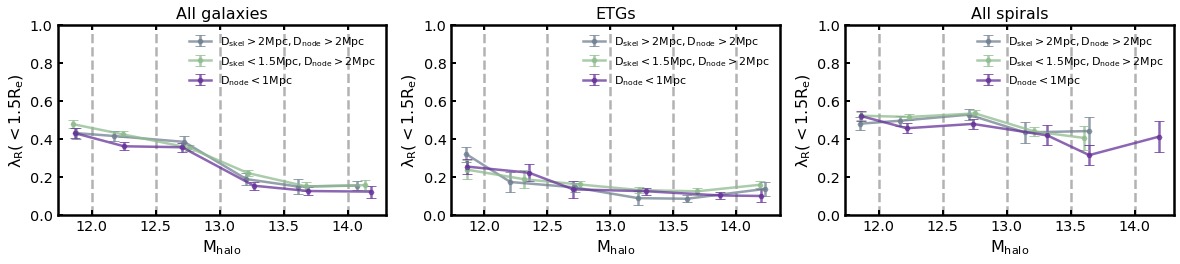

In [79]:
fig, ax = plt.subplots(1,3, figsize=(20, 3.5))

## all galaxies
x_bins = np.array([12, 12.5, 13, 13.5, 14]) 
z_percentiles = np.array([])
x_quantity = ncw_tab.halo_mass_stel.values
z_quantity = ncw_tab.stellar_to_halo_ratio.values
y_quantity = ncw_tab.lambda_re.values
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{skel} > 2Mpc, D_{node} > 2Mpc}$'], ax[0], colors=['slategrey'])
x_quantity = filament_tab.halo_mass_stel.values
z_quantity = filament_tab.stellar_to_halo_ratio.values
y_quantity = filament_tab.lambda_re.values
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{skel} < 1.5Mpc, D_{node} > 2Mpc}$'], ax[0], colors=['darkseagreen'])
x_quantity = node_tab.halo_mass_stel.values
z_quantity = node_tab.stellar_to_halo_ratio.values
y_quantity = node_tab.lambda_re.values
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{node} < 1Mpc}$'], ax[0], colors=['rebeccapurple'])
for x in x_bins:
    ax[0].axvline(x, color='k', alpha=0.3, linestyle='dashed')
ax[0].legend(frameon=False, fontsize=11)
ax[0].set_ylabel(r'$\mathrm{log_{10}(D_{skel})}$', fontsize=16)
ax[0].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[0].set_title('All galaxies', fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)

## etgs
x_bins = np.array([12, 12.5, 13, 13.5, 14]) 
z_percentiles = np.array([])
x_quantity = ncw_etgs_tab.halo_mass_stel.values
z_quantity = ncw_etgs_tab.stellar_to_halo_ratio.values
y_quantity = ncw_etgs_tab.lambda_re.values
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{skel} > 2Mpc, D_{node} > 2Mpc}$'], ax[1], colors=['slategrey'])
x_quantity = filament_etgs_tab.halo_mass_stel.values
z_quantity = filament_etgs_tab.stellar_to_halo_ratio.values
y_quantity = filament_etgs_tab.lambda_re.values
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{skel} < 1.5Mpc, D_{node} > 2Mpc}$'], ax[1], colors=['darkseagreen'])
x_quantity = node_etgs_tab.halo_mass_stel.values
z_quantity = node_etgs_tab.stellar_to_halo_ratio.values
y_quantity = node_etgs_tab.lambda_re.values
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{node} < 1Mpc}$'], ax[1], colors=['rebeccapurple'])
for x in x_bins:
    ax[1].axvline(x, color='k', alpha=0.3, linestyle='dashed')
ax[1].legend(frameon=False, fontsize=11)
ax[1].set_ylabel(r'$\mathrm{log_{10}(D_{skel})}$', fontsize=16)
ax[1].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[1].set_title('ETGs', fontsize=16)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)

## all spirals
x_bins = np.array([12, 12.5, 13, 13.5, 14]) 
x_quantity = ncw_all_spirals_tab.halo_mass_stel.values
z_quantity = ncw_all_spirals_tab.stellar_to_halo_ratio.values
y_quantity = ncw_all_spirals_tab.lambda_re.values
z_percentiles = np.array([])
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{skel} > 2Mpc, D_{node} > 2Mpc}$'], ax[2], colors=['slategrey'])
x_quantity = filament_all_spirals_tab.halo_mass_stel.values
z_quantity = filament_all_spirals_tab.stellar_to_halo_ratio.values
y_quantity = filament_all_spirals_tab.lambda_re.values
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{skel} < 1.5Mpc, D_{node} > 2Mpc}$'], ax[2], colors=['darkseagreen'])
x_quantity = node_all_spirals_tab.halo_mass_stel.values
z_quantity = node_all_spirals_tab.stellar_to_halo_ratio.values
y_quantity = node_all_spirals_tab.lambda_re.values
sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['$\mathrm{D_{node} < 1Mpc}$'], ax[2], colors=['rebeccapurple'])

for x in x_bins:
    ax[2].axvline(x, color='k', alpha=0.3, linestyle='dashed')
ax[2].legend(frameon=False, fontsize=11)
ax[2].set_ylabel(r'$\mathrm{log_{10}(D_{skel})}$', fontsize=16)
ax[2].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[2].set_title('All spirals', fontsize=16)
ax[2].set_ylim([0, 1])
ax[2].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)

plt.savefig(outpath+'lambdaR_mhalo_cw_and_morph_split.pdf', format='pdf', bbox_inches='tight')